# [TensorFlow Mechanics 101](https://www.tensorflow.org/get_started/mnist/mechanics)

In [1]:
import math
import time
import os
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.examples.tutorials.mnist import mnist
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare the Data

### Download data

In [2]:
ds = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(ds.train.images.shape, ds.train.images.dtype)
print(ds.train.labels.shape, ds.train.labels.dtype)

(55000, 784) float32
(55000,) uint8


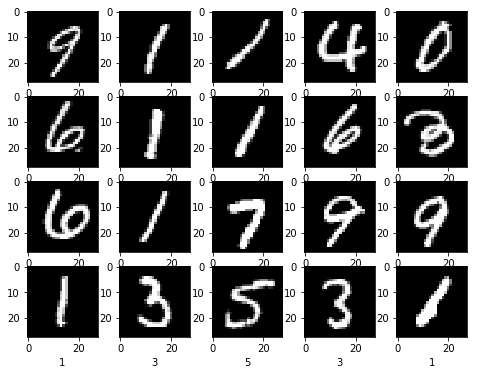

In [4]:
nTrain = ds.train.images.shape[0]
nImgs = 20
indices = np.random.randint(low=0, high=nTrain, size=[nImgs])
imgs = ds.train.images[indices, :]
lbls = ds.train.labels[indices]

nCols = 5
nRows = math.ceil(nImgs / nCols)
plt.figure(figsize=(8, 6))
for i in range(nImgs):
    plt.subplot(nRows, nCols, i + 1)
    plt.imshow(X=np.reshape(a=imgs[i, :], newshape=[28, 28]), cmap='gray')
    plt.xlabel(lbls[i])

### Inputs and Placeholder

In [5]:
BATCH_SIZE = 100

images_p = tf.placeholder(dtype=tf.float32, shape=(BATCH_SIZE, mnist.IMAGE_PIXELS), name='images')
labels_p = tf.placeholder(dtype=tf.float32, name='labels')
print(images_p)
print(labels_p)

Tensor("images:0", shape=(100, 784), dtype=float32)
Tensor("labels:0", dtype=float32)


## Build the Graph

### Inference

In [6]:
HIDDEN_UNITS_1 = 24

with tf.name_scope('hidden1'):
    weights = tf.Variable(tf.truncated_normal([mnist.IMAGE_PIXELS, HIDDEN_UNITS_1]), name='weights')
    biases = tf.Variable(tf.zeros([HIDDEN_UNITS_1]), name='biases') 
    hidden1 = tf.nn.relu(tf.matmul(images_p, weights) + biases, name='hidden1')
    
    print(weights)
    print(biases)
    print(hidden1)

Tensor("hidden1/weights/read:0", shape=(784, 24), dtype=float32)
Tensor("hidden1/biases/read:0", shape=(24,), dtype=float32)
Tensor("hidden1/hidden1:0", shape=(100, 24), dtype=float32)


In [7]:
HIDDEN_UNITS_2 = 32

with tf.name_scope('hidden2'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS_1, HIDDEN_UNITS_2]), name='weights')
    biases = tf.Variable(tf.zeros(HIDDEN_UNITS_2), name='biases')
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases, name='hidden2')
    
    print(weights)
    print(biases)
    print(hidden2)

Tensor("hidden2/weights/read:0", shape=(24, 32), dtype=float32)
Tensor("hidden2/biases/read:0", shape=(32,), dtype=float32)
Tensor("hidden2/hidden2:0", shape=(100, 32), dtype=float32)


In [8]:
CLASSES = 10

with tf.name_scope('linear'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN_UNITS_2, CLASSES]), name='weights')
    biases = tf.Variable(tf.zeros(CLASSES), name='biases')
    logits = tf.matmul(hidden2, weights) + biases
    
    print(weights)
    print(biases)
    print(logits)

Tensor("linear/weights/read:0", shape=(32, 10), dtype=float32)
Tensor("linear/biases/read:0", shape=(10,), dtype=float32)
Tensor("linear/add:0", shape=(100, 10), dtype=float32)


### Loss

In [9]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.to_int32(labels_p), logits=logits, name='xentropy')
loss = tf.reduce_mean(xentropy, name='loss')

print(xentropy)
print(loss)

Tensor("xentropy/xentropy:0", shape=(100,), dtype=float32)
Tensor("loss:0", shape=(), dtype=float32)


### Training

In [10]:
LEARNING_RATE = 0.001
LOG_DIR = 'logs/TensorFlow Mechanics'
CHECKPOINT_FILE = os.path.join(LOG_DIR, 'model.ckpt')
tf.summary.scalar('loss', loss)

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
global_step = tf.Variable(0, name='global_step', trainable=False)
train = optimizer.minimize(loss, global_step=global_step)
evaluation = mnist.evaluation(logits=logits, labels=tf.to_int32(labels_p))
summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

print(optimizer)
print(global_step)
print(type(train))
print(evaluation)
print(summary)
print(type(init))
print(saver)

Tensor("global_step/read:0", shape=(), dtype=int32)
<class 'tensorflow.python.framework.ops.Operation'>
Tensor("Sum:0", shape=(), dtype=int32)
Tensor("Merge/MergeSummary:0", shape=(), dtype=string)
<class 'tensorflow.python.framework.ops.Operation'>


## Train the Model

In [11]:
def nextFeedDict(images_placeholders, labels_placeholders, datasets):
    images_feed, labels_feed = datasets.next_batch(BATCH_SIZE)
    return {images_placeholders: images_feed, labels_placeholders: labels_feed}

In [12]:
def evaluate(session, evaluation, images_placeholders, labels_placeholders, datasets):
    true_count = 0
    steps_per_epoch = datasets.num_examples // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    
    for step in range(steps_per_epoch):
        feed_dict = nextFeedDict(images_placeholders, labels_placeholders, datasets)
        true_count += session.run(evaluation, feed_dict=feed_dict)
        
    accuracy = float(true_count) / num_examples
    print('Examples: {0} - Correct: {1} - Accuracy: {2}'.format(num_examples, true_count, accuracy))

In [22]:
MAX_STEPS = 4000

with tf.Graph().as_default():
    with tf.Session() as sess:
        sess.run(init)
        summary_writer = tf.summary.FileWriter(logdir=LOG_DIR, graph=sess.graph)
        
        for step in range(MAX_STEPS):
            start = time.time()
            feed_dict = nextFeedDict(images_placeholders=images_p, labels_placeholders=labels_p, datasets=ds.train)
            _, lossRes = sess.run([train, loss], feed_dict=feed_dict)
            
            if step % 400 == 0:
                print('Step {0}: loss {1} (in {2})'.format(step, lossRes, time.time() - start))
                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()
                
            if (step + 1) % 1000 == 0 or (step + 1) == MAX_STEPS:
                saver.save(save_path=CHECKPOINT_FILE, global_step=global_step, sess=sess)
                evaluate(evaluation=evaluation, images_placeholders=images_p, labels_placeholders=labels_p, datasets=ds.train)
                evaluate(evaluation=evaluation, images_placeholders=images_p, labels_placeholders=labels_p, datasets=ds.validation)
                evaluate(evaluation=evaluation, images_placeholders=images_p, labels_placeholders=labels_p, datasets=ds.test)

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [20]:
class Obj:
    def __enter__(self):
        pass
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

with Obj():
    ab = 5
    cd = 6
    
ab

5